# LeNet-5

_Introduction by Ivanovitch Silva_

Perhaps the first widely known and successful application of convolutional neural networks was **LeNet-5**, described by Yann LeCun, et al. in their 1998 paper titled [Gradient-Based Learning Applied to Document Recognition](https://ieeexplore.ieee.org/document/726791). The system was developed for use in a handwritten character recognition problem and demonstrated on the **MNIST standard dataset**, achieving approximately 99.2% classification accuracy (or a 0.8% error rate). The network was then described as the central technique in a broader system referred to as **Graph Transformer Networks**.

It is a long paper, and perhaps the best part to focus on is Section II. B. that describes the LeNet-5 architecture. In that section, the paper describes the **network as having seven layers** with input **grayscale images** having the shape **32 x 32**, the size of images in the **MNIST dataset**. 

> The model proposes a pattern of a convolutional layer followed by an average pooling layer, referred to as a **subsampling layer**. 

This pattern is repeated two and a half times before the output feature maps are flattened and fed to some fully connected layers for interpretation and a final prediction. A picture of the network architecture is provided in the paper and reproduced below.

<img width="800" src="https://drive.google.com/uc?export=view&id=1nqbLzHfqorX80I8upHMWINwPNfrmLW-V"/>

The pattern of blocks of convolutional layers and pooling layers (referred to as **subsampling**) grouped and repeated **remains a typical pattern in designing and using convolutional neural networks today, more than twenty years later**. Interestingly, the architecture uses a small number of filters with a modest size as the first hidden layer, specifically 6 filters, each with 5x5 pixels. After pooling, another convolutional layer has many more filters, again with the same size, precisely 16 filters with 5x5 pixels, again followed by pooling. In the repetition of these two blocks of convolution and pooling layers, the trend increases the number of filters.

Compared to modern applications, the number of filters is also small, but **the trend of increasing the number of filters with the depth of the network also remains a common pattern in modern usage of the technique.** The flattening of the feature maps and interpretation and classification of the extracted features by fully connected layers also remains a common pattern today. 

> In modern terminology, the **final section of the architecture** is often referred to as the **classifier**, whereas the **convolutional and pooling layers** earlier in the model are referred to as the **feature extractor**.

We can summarize the key aspects of the architecture relevant in modern models as follows:

- Fixed-sized input images.
- Group convolutional and pooling layers into blocks.
- Repetition of convolutional-pooling blocks in the architecture.
- Increase in the number of filters with the depth of the network.
- Distinct feature extraction and classifier parts of the architecture.

# But What If....

Even though LeNet is awesome, couldn't we improve it? For example...
- the original lenet uses _tanh_ activation function. On the other hand, [Goodfellow et al.](https://www.deeplearningbook.org/contents/mlp.html) (2016) comments that _ReLu_ activation function is easier to optimize; 
- [Dropout (2014)](https://www.cs.toronto.edu/~rsalakhu/papers/srivastava14a.pdf) and [Batch Normalization (2015)](https://arxiv.org/abs/1502.03167) are popular ideas that appeared only a decade after the LeNet was published.

Thus, this is a good opportunity to try them out. In order to do this, let's use [WandB Sweeps](https://docs.wandb.ai/guides/sweeps). 

The rest of this file (such as the Intro) were borrowed from [Ivanovitch Silva's code](https://github.com/ivanovitchm/embedded.ai/blob/main/lessons/week_08/LeNet.ipynb), and modified as needed. Contrary to the original file, this one does not contain Data Augmentation and does not explicitly implement the IvanNet, since the goal is to try the use of ReLu, Dropout and BatchNorm. It is important to notice that, by using Dropout and BatchNorm, we try IvanNet as well (since these modifications were applied in it).

## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Packages

In [ ]:
# import the necessary packages
import logging
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### WandB Login

In [ ]:
wandb.login()

True

### Logger

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

### Project Name

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "lenet-5-assignment"
}

## Step 02: Implementing *a new, modified version of* LeNet-5

Below we see the original LeNet-5, as proposed by Yann Lecun.

<img width="800" src="https://drive.google.com/uc?export=view&id=1RF_HWPSImajab-i1ayFeEOoFON0Ky-28"/>

Below, however, we'll accomodate some modifications to  be tested by the sweep:
- BatchNorm after convolutional mappings C1 and C3;
- Dropout after subsampling S2 and S4;

They will not be hard-coded. Instead, the sweeps will control the addition or not of them.

Source code based on [**Rosebrock, Adrian. Deep Learning For Computer vision with Python, 2019**](https://pyimagesearch.com/deep-learning-computer-vision-python-book/)

In [ ]:
class LeNet:
  ''' 
  # create LeNet-5 model
  #
  # it is composed of the 8 layers (5 layers considering FC as one layer) 
  # such as:
  #      - 2 convolutional layers
  #      - 2 subsampling (avg pooling) layers
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 10 outputs
  '''
  @staticmethod
  def build(width, height, depth, classes, activation_function, batch_norm = False, dropout = 0.0):
    if not activation_function == 'tanh' and not activation_function == 'relu':
      raise ValueError('Wrong Activation Function')
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(6, (5,5), strides=1, padding='same',
                     activation=activation_function, input_shape=(28,28,1), )) #C1
    if batch_norm: # is batch norm is selected, add a BatchNorm layer
      model.add(BatchNormalization())

    model.add(AveragePooling2D()) #S2

    if dropout > 0.0: # is some dropout percentage will be applied, add Dropout if that percentage
      model.add(Dropout(dropout))


    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(16, (5,5), strides=1, padding='valid',
                     activation=activation_function)) #C3
    if batch_norm: # is batch norm is selected, add a BatchNorm layer
      model.add(BatchNormalization())

    model.add(AveragePooling2D()) #S4

    # a flatten and two set of FC => RELU layers
    model.add(Flatten()) #Flatten
    model.add(Dense(120, activation = activation_function)) #C5

    if dropout > 0.0: # is some dropout percentage will be applied, add Dropout if that percentage
      model.add(Dropout(dropout))
      
    model.add(Dense(84, activation = activation_function)) #F6
    if dropout > 0.0:
      model.add(Dropout(dropout))

    # softmax classifier
    model.add(Dense(10, activation='softmax')) #Output layer
    
    # return the constructed network architecture
    return model

In [ ]:
# create a model object for testing purposes
model = LeNet.build(28,28,1,10,activation_function = 'tanh',batch_norm=True, dropout=0.0,)

# summarize layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 6)        24        
 hNormalization)                                                 
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 batch_normalization_5 (Batc  (None, 10, 10, 16)       64        
 hNormalization)                                                 
                                                      

## Step 03: Hyperparameter Definition

Sweeps is a Weights and Biases tool for easy Hyperparameter Tuning visualization. Here I define the parameters to be tested and their testing values.

In [ ]:
hyperp = {
    'dropout':{
        'values': [0.0,0.1, 0.5]
    },
    'batch_norm': {
        'values':[True,False] 
    },
    'activation_function':{
        'values':['tanh','relu']
    }
}
sweep_config = {
    'method': 'grid',
    'metric':{
        'name': 'best_loss',
        'goal': 'minimize'
    },
    'parameters': hyperp
}
sweep_id = wandb.sweep(sweep_config, entity="mtxslv", project=args["project_name"])

Create sweep with ID: 1tomkau0
Sweep URL: https://wandb.ai/mtxslv/lenet-5-assignment/sweeps/1tomkau0


## Step 04: LeNet-5 on MNIST (Sweeps)

### Fetch, Preprocessing and Data Segregation

In [ ]:
# grab the MNIST dataset (if this is your first time using this
# dataset then the 11MB download may take a second)
logger.info("[INFO] accessing MNIST...")
((train_x, train_y), (test_x, test_y)) = mnist.load_data()

logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

30-10-2022 18:07:53 [INFO] accessing MNIST...
30-10-2022 18:07:54 Train x: (60000, 28, 28)
30-10-2022 18:07:54 Train y: (60000,)
30-10-2022 18:07:54 Test x: (10000, 28, 28)
30-10-2022 18:07:54 Test y: (10000,)


In [ ]:
# if we are using "channels first" ordering, then reshape the
# design matrix such that the matrix is:
# num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	train_x = train_x.reshape((train_x.shape[0], 1, 28, 28))
	test_x = test_x.reshape((test_x.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
	test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [ ]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

30-10-2022 18:07:54 Train x: (60000, 28, 28, 1)
30-10-2022 18:07:54 Train y: (60000,)
30-10-2022 18:07:54 Test x: (10000, 28, 28, 1)
30-10-2022 18:07:54 Test y: (10000,)


In [ ]:
# scale data to the range of [0, 1]
train_x = train_x.astype("float32") / 255.0
test_x = test_x.astype("float32") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
train_y = lb.fit_transform(train_y)
test_y = lb.transform(test_y)

### Training Function (necessary for Sweeps use)

In [ ]:
def train():
  # define run
  run = wandb.init(entity="mtxslv",
                   project=args["project_name"], 
                   job_type="Train")
  # initial config for running the first sweep
  config = {
      'activation_function': 'tanh',
      'batch_norm' : False, 
      'dropout' : 0.0
  }
  # create codecarbon tracker
  # codecarbon is too much verbose, change the log level for more info
  tracker = EmissionsTracker(log_level="critical")
  tracker.start()

  # initialize the optimizer and model
  logger.info("[INFO] compiling model...")
  opt = Adam(learning_rate=0.01)
  model = LeNet.build(width=28, 
                      height=28, 
                      depth=1, 
                      classes=10,
                      activation_function = wandb.config.activation_function,
                      batch_norm = wandb.config.batch_norm, 
                      dropout = wandb.config.dropout)
  # compile model
  model.compile(loss="categorical_crossentropy", optimizer=opt,
                metrics=["accuracy"])

  # train the network
  logger.info("[INFO] training network...")
  history = model.fit(train_x, train_y,
                validation_data=(test_x, test_y),
                batch_size=32,
                epochs=20, 
                verbose=0,
                callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                    compute_flops=True)])

  # get co2 emissions from tracker
  # "CO2 emission (in Kg)"
  emissions = tracker.stop()

  predictions = model.predict(test_x, batch_size=32)
  fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
  ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                          test_y.argmax(axis=1)),
                        display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

  ax.set_xlabel("True Label")
  ax.set_ylabel("Predicted Label")
  ax.grid(False)

  # Uploading figures
  logger.info("Uploading figures")
  run.log(
      {
          "confusion_matrix": wandb.Image(fig_confusion_matrix),
          # "other_figure": wandb.Image(other_fig)
      }
  )
  # Evaluation Metrics
  logger.info("Validation Evaluation metrics")
  fbeta = fbeta_score(test_y.argmax(axis=1), 
                      predictions.argmax(axis=1), 
                      beta=1, zero_division=1,average='weighted')
  precision = precision_score(test_y.argmax(axis=1),
                              predictions.argmax(axis=1),
                              zero_division=1,average='weighted')
  recall = recall_score(test_y.argmax(axis=1),
                        predictions.argmax(axis=1),
                        zero_division=1,average='weighted')
  acc = accuracy_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1))

  logger.info("Validation Accuracy: {}".format(acc))
  logger.info("Validation Precision: {}".format(precision))
  logger.info("Validation Recall: {}".format(recall))
  logger.info("Validation F1: {}".format(fbeta))

  run.summary["Acc"] = acc
  run.summary["Precision"] = precision
  run.summary["Recall"] = recall
  run.summary["F1"] = fbeta
  # number of parameters
  run.summary["Count_Params"] = model.count_params()
  # energy unit is kWh
  run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
  run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
  run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
  run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
  # kg
  run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

### WandB Agent

wandb: Agent Starting Run: tjj9p1rk with config:
wandb: 	activation_function: tanh
wandb: 	batch_norm: True
wandb: 	dropout: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:08:03 [INFO] compiling model...
30-10-2022 18:08:03 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:10:28 Uploading figures
30-10-2022 18:10:28 Validation Evaluation metrics
30-10-2022 18:10:28 Validation Accuracy: 0.9039
30-10-2022 18:10:28 Validation Precision: 0.9127334926035406
30-10-2022 18:10:28 Validation Recall: 0.9039
30-10-2022 18:10:28 Validation F1: 0.905282038454233


accuracy,▆████▆▇▆▆▆▅▇▅▄▅▅▂▁▂▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▃▁▁▁▁▃▂▃▃▃▄▂▄▅▄▄██▇█
val_accuracy,▇▅▆▇█▇▆▃▆▄▇▇▅▇▆▄▁▂▂▁
val_loss,▁▅▄▂▁▃▃▆▃▅▃▂▃▂▄▅█▆▇█
Acc,0.9039
CO2_Emissions,0.00191
Count_Params,61794
Energy_CPU,0.00169
Energy_Consumed,0.00303
Energy_GPU,0.00115


wandb: Agent Starting Run: j6em09lp with config:
wandb: 	activation_function: tanh
wandb: 	batch_norm: True
wandb: 	dropout: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:10:45 [INFO] compiling model...
30-10-2022 18:10:45 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:12:50 Uploading figures
30-10-2022 18:12:51 Validation Evaluation metrics
30-10-2022 18:12:51 Validation Accuracy: 0.8862
30-10-2022 18:12:51 Validation Precision: 0.8896440634123528
30-10-2022 18:12:51 Validation Recall: 0.8862
30-10-2022 18:12:51 Validation F1: 0.8863021011290966


accuracy,▆███▇▆▇▅▅▅▆▄▆▆▆▃▄▄▅▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▃▂▁▁▂▃▂▃▃▄▃▅▃▃▃▅▅▅▄█
val_accuracy,█▆██▅▇▆▆▆▆▄▆▇▅▆▂▇▅▆▁
val_loss,▁▃▁▁▄▁▂▃▃▃▅▃▂▄▃█▂▄▃█
Acc,0.8862
CO2_Emissions,0.00169
Count_Params,61794
Energy_CPU,0.00147
Energy_Consumed,0.00268
Energy_GPU,0.00104


wandb: Agent Starting Run: tetnbrh4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_norm: True
wandb: 	dropout: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:13:03 [INFO] compiling model...
30-10-2022 18:13:03 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:15:12 Uploading figures
30-10-2022 18:15:12 Validation Evaluation metrics
30-10-2022 18:15:12 Validation Accuracy: 0.9262
30-10-2022 18:15:12 Validation Precision: 0.9278862760156711
30-10-2022 18:15:12 Validation Recall: 0.9262
30-10-2022 18:15:12 Validation F1: 0.9261657926600984


accuracy,▄███▇▆▇▅▅▄▂▁▃▄▄▁▂▅▃▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▄▁▁▁▂▃▂▄▅▅▇█▆▅▅█▇▅▆▇
val_accuracy,▄▇▆▆▇█▇▇▆▁▅▆▆▇▆▅▆▆▆▄
val_loss,▄▂▃▃▂▁▁▂▃█▄▄▃▂▂▄▃▃▃▅
Acc,0.9262
CO2_Emissions,0.00174
Count_Params,61794
Energy_CPU,0.00152
Energy_Consumed,0.00276
Energy_GPU,0.00107


wandb: Agent Starting Run: 0qznlhmz with config:
wandb: 	activation_function: tanh
wandb: 	batch_norm: False
wandb: 	dropout: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:15:30 [INFO] compiling model...
30-10-2022 18:15:30 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:17:53 Uploading figures
30-10-2022 18:17:53 Validation Evaluation metrics
30-10-2022 18:17:54 Validation Accuracy: 0.9614
30-10-2022 18:17:54 Validation Precision: 0.9617197827308998
30-10-2022 18:17:54 Validation Recall: 0.9614
30-10-2022 18:17:54 Validation F1: 0.961409737857637


accuracy,▁▅▆▆▇▇▇▇▇█▇████▇▆█▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▃▂▂▂▂▁▁▁▁▂▃▁▂▁
val_accuracy,▁▅▄▅▆▅▄▆▆▆▇▇█▇▄▆▅▇▆█
val_loss,█▄▅▄▃▄▅▃▂▃▃▃▂▃▅▄▄▂▃▁
Acc,0.9614
CO2_Emissions,0.00193
Count_Params,61706
Energy_CPU,0.00168
Energy_Consumed,0.00305
Energy_GPU,0.00118


wandb: Agent Starting Run: 6z11ko7p with config:
wandb: 	activation_function: tanh
wandb: 	batch_norm: False
wandb: 	dropout: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:18:13 [INFO] compiling model...
30-10-2022 18:18:13 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:20:37 Uploading figures
30-10-2022 18:20:37 Validation Evaluation metrics
30-10-2022 18:20:37 Validation Accuracy: 0.9588
30-10-2022 18:20:37 Validation Precision: 0.9593609575767361
30-10-2022 18:20:37 Validation Recall: 0.9588
30-10-2022 18:20:37 Validation F1: 0.9587362626820539


accuracy,▁▅▆▆▇▇▇▆▇▇███▇▇▇███▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▂
val_accuracy,▅▅▁▅▇▇▇▇██▇██▆▇███▇█
val_loss,▄▄█▄▂▃▂▂▁▁▁▁▁▃▂▂▁▁▂▁
Acc,0.9588
CO2_Emissions,0.00193
Count_Params,61706
Energy_CPU,0.00169
Energy_Consumed,0.00305
Energy_GPU,0.00118


wandb: Agent Starting Run: wlaayouw with config:
wandb: 	activation_function: tanh
wandb: 	batch_norm: False
wandb: 	dropout: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:20:57 [INFO] compiling model...
30-10-2022 18:20:58 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:23:21 Uploading figures
30-10-2022 18:23:21 Validation Evaluation metrics
30-10-2022 18:23:21 Validation Accuracy: 0.9475
30-10-2022 18:23:21 Validation Precision: 0.9477035988970552
30-10-2022 18:23:21 Validation Recall: 0.9475
30-10-2022 18:23:21 Validation F1: 0.9473165228033001


accuracy,▁▅▆▆▇▆▇▇▇▇▇██▇▇██▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▃▃▂▃▃▃▂▁▂▂▂▁▂▂▁
val_accuracy,▁▂▂▁▅▁▄▄▄▃▅▄▅▆▆▅▆▄▇█
val_loss,█▇█▇▅▆▆▄▄▅▅▅▄▁▂▁▃▆▃▁
Acc,0.9475
CO2_Emissions,0.00193
Count_Params,61706
Energy_CPU,0.00169
Energy_Consumed,0.00306
Energy_GPU,0.00118


wandb: Agent Starting Run: ucwkzc4i with config:
wandb: 	activation_function: relu
wandb: 	batch_norm: True
wandb: 	dropout: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:23:40 [INFO] compiling model...
30-10-2022 18:23:41 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:26:05 Uploading figures
30-10-2022 18:26:05 Validation Evaluation metrics
30-10-2022 18:26:05 Validation Accuracy: 0.985
30-10-2022 18:26:05 Validation Precision: 0.9852089862210083
30-10-2022 18:26:05 Validation Recall: 0.985
30-10-2022 18:26:05 Validation F1: 0.9850319608777621


accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▂▃▂▂▂▂▃▂▂▂▁▂▂▁▂▂
val_accuracy,▁▅▆▅▆▅▅▆▇▇▃▃█▆▆▆▆█▇▆
val_loss,▆▁▃▃▁▃▅▂▃▅▅▆▁▂▃▇█▄▅▂
Acc,0.985
CO2_Emissions,0.00193
Count_Params,61794
Energy_CPU,0.00169
Energy_Consumed,0.00306
Energy_GPU,0.00118


wandb: Agent Starting Run: nunm2p32 with config:
wandb: 	activation_function: relu
wandb: 	batch_norm: True
wandb: 	dropout: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:26:21 [INFO] compiling model...
30-10-2022 18:26:21 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:28:45 Uploading figures
30-10-2022 18:28:45 Validation Evaluation metrics
30-10-2022 18:28:45 Validation Accuracy: 0.9867
30-10-2022 18:28:45 Validation Precision: 0.9867716802675084
30-10-2022 18:28:45 Validation Recall: 0.9867
30-10-2022 18:28:45 Validation F1: 0.986707905393866


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇▇▇▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▃▂▂▃▂▂▂▂▁▁▁
val_accuracy,▅▁▅▇▇▁▆▃▂▇▃▇▇▆▆█▇▅▆▇
val_loss,▂▄▁▁▂▄▂▅▇▂█▁▃█▄▂▂▅▅▆
Acc,0.9867
CO2_Emissions,0.00194
Count_Params,61794
Energy_CPU,0.00169
Energy_Consumed,0.00308
Energy_GPU,0.0012


wandb: Agent Starting Run: jplj8de6 with config:
wandb: 	activation_function: relu
wandb: 	batch_norm: True
wandb: 	dropout: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:29:06 [INFO] compiling model...
30-10-2022 18:29:06 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:31:13 Uploading figures
30-10-2022 18:31:13 Validation Evaluation metrics
30-10-2022 18:31:13 Validation Accuracy: 0.9817
30-10-2022 18:31:13 Validation Precision: 0.9819360774046596
30-10-2022 18:31:13 Validation Recall: 0.9817
30-10-2022 18:31:13 Validation F1: 0.9817157260354284


accuracy,▁▆▇▇▇█▇▇█▇█▇█▇██████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▂▂▂▂▁▂▂▁▂▂▂▁▂▁▂▁▂▁▂
val_accuracy,▃▆▆▆▇▇▆▇█▅▁▆▇▆▇█▇▆█▇
val_loss,▇▃▄▄▃▃▃▂▁▆█▃▄▄▃▃▂▄▃▃
Acc,0.9817
CO2_Emissions,0.0017
Count_Params,61794
Energy_CPU,0.00148
Energy_Consumed,0.00269
Energy_GPU,0.00105


wandb: Agent Starting Run: dum9es5o with config:
wandb: 	activation_function: relu
wandb: 	batch_norm: False
wandb: 	dropout: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:31:33 [INFO] compiling model...
30-10-2022 18:31:33 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:33:27 Uploading figures
30-10-2022 18:33:27 Validation Evaluation metrics
30-10-2022 18:33:27 Validation Accuracy: 0.9813
30-10-2022 18:33:27 Validation Precision: 0.9816045130220977
30-10-2022 18:33:27 Validation Recall: 0.9813
30-10-2022 18:33:27 Validation F1: 0.9813225369980352


accuracy,▁▅▆▆▆▇▇▇▇▇▇▇██▇██▇██
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▄▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▂▁▁
val_accuracy,▁▅▁▇▃█▇▇▆▅▄▄▅▄▇▆▇█▆▅
val_loss,▄▃▄▁▅▂▂▂▃▄█▆▅▄▄▄▄▃▅▆
Acc,0.9813
CO2_Emissions,0.00153
Count_Params,61706
Energy_CPU,0.00133
Energy_Consumed,0.00243
Energy_GPU,0.00095


wandb: Agent Starting Run: 5xzqe0ve with config:
wandb: 	activation_function: relu
wandb: 	batch_norm: False
wandb: 	dropout: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:33:45 [INFO] compiling model...
30-10-2022 18:33:45 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:36:08 Uploading figures
30-10-2022 18:36:08 Validation Evaluation metrics
30-10-2022 18:36:08 Validation Accuracy: 0.9847
30-10-2022 18:36:08 Validation Precision: 0.984747650393069
30-10-2022 18:36:08 Validation Recall: 0.9847
30-10-2022 18:36:08 Validation F1: 0.9846983354373753


accuracy,▁▆▆▇▇▇▇▇████▇█▇█████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▂▂
val_accuracy,▁▅▇▅▇▇▇█▇██▇▇▇█▇▇▅██
val_loss,█▃▁▄▂▂▃▁▁▁▁▂▃▃▂▂▃▆▁▁
Acc,0.9847
CO2_Emissions,0.00193
Count_Params,61706
Energy_CPU,0.00168
Energy_Consumed,0.00306
Energy_GPU,0.00119


wandb: Agent Starting Run: ggp88iin with config:
wandb: 	activation_function: relu
wandb: 	batch_norm: False
wandb: 	dropout: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


30-10-2022 18:36:28 [INFO] compiling model...
30-10-2022 18:36:28 [INFO] training network...


313/313 [==============================] - 1s 2ms/step


30-10-2022 18:38:51 Uploading figures
30-10-2022 18:38:51 Validation Evaluation metrics
30-10-2022 18:38:51 Validation Accuracy: 0.9705
30-10-2022 18:38:52 Validation Precision: 0.9707669026901135
30-10-2022 18:38:52 Validation Recall: 0.9705
30-10-2022 18:38:52 Validation F1: 0.9704984149150016


accuracy,▁▇▇██████▇█▇█▇▇▇▇███
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▁▁▁▁▁▂▂▁▂▁▂▁▂▂▂▂▂▂▂
val_accuracy,▃▄▃▇▇▄██▅▅▄█▁▁█▆█▄▅▇
val_loss,▄▃▄▂▂▃▁▂▃▂▆▂▇█▂▄▅█▃▃
Acc,0.9705
CO2_Emissions,0.00193
Count_Params,61706
Energy_CPU,0.00168
Energy_Consumed,0.00306
Energy_GPU,0.00119


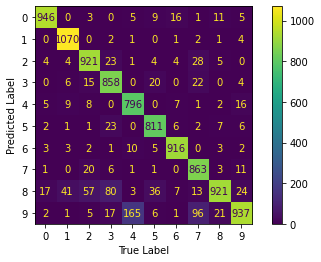

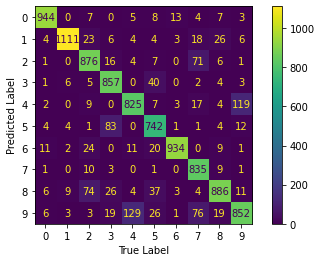

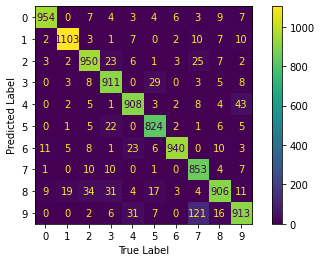

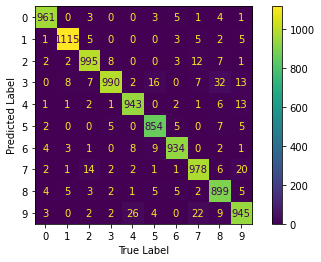

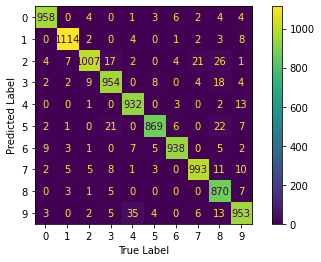

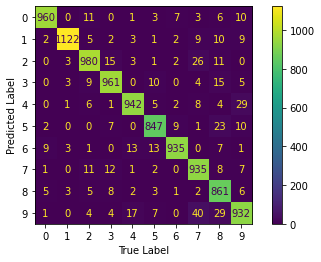

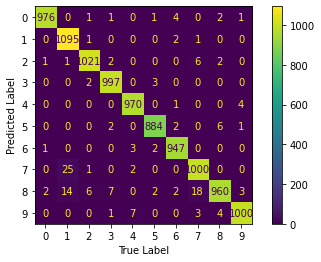

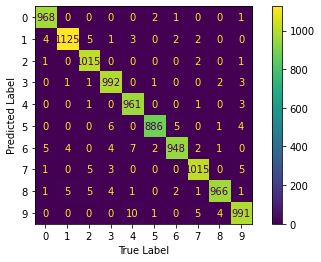

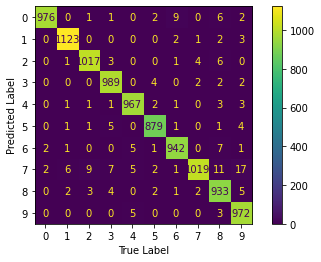

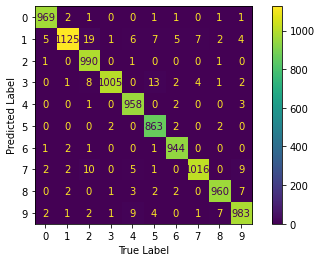

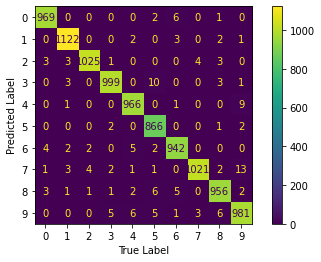

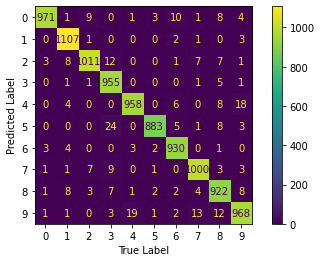

In [ ]:
wandb.agent(sweep_id, function=train, count = 12)